In [1]:
import numpy as np
import pandas as pd
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import matplotlib.pyplot as plt

from sys import path as pylib #im naming it as pylib so that we won't get confused between os.path and sys.path 
import os
pylib += [os.path.abspath(r'/home/Jay/Notebooks/Group9_emotion_detection/torchMoji')]

In [2]:
data = pd.read_csv('../../deepmoji/data/train.txt', sep = '\t')

In [3]:
label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

emoticons_additional = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_additional]
)


def tokenize(text):
    text = " ".join(text_processor.pre_process_doc(text))
    return text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


### Load raw data

In [4]:
x1=[]
x2=[]
x3=[]
y=[]
labels={}
i=0
for ind, row in data.iterrows():
    y.append(emotion2label[row['label']])
    x1.append(tokenize(row['turn1']))
    x2.append(tokenize(row['turn2']))
    x3.append(tokenize(row['turn3']))

In [5]:
test_data = pd.read_csv('../../deepmoji/data/test.txt', sep = '\t')
test_x1=[]
test_x2=[]
test_x3=[]
test_y_all=[]
test_labels={}
i=0
for ind, row in test_data.iterrows():
    test_y_all.append(emotion2label[row['label']])
    test_x1.append(tokenize(row['turn1']))
    test_x2.append(tokenize(row['turn2']))
    test_x3.append(tokenize(row['turn3']))

In [6]:
from __future__ import print_function, division, unicode_literals
import json

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

def encode_deepmoji(x):
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    model = torchmoji_feature_encoding(PRETRAINED_PATH)
    print(model)
    print('Encoding texts..')
    encoding = np.zeros((len(x), 2304))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

def encode_emoji(x):
    model = torchmoji_emojis(PRETRAINED_PATH)
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    print(model)
    print('Running predictions.')
    
    encoding = np.zeros((len(x), 64))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

In [7]:
x1_vec = np.load('../../dm_emb/deepmoji_train_x1.npy')
x2_vec = np.load('../../dm_emb/deepmoji_train_x2.npy')
x3_vec = np.load('../../dm_emb/deepmoji_train_x3.npy')

In [8]:
deepmoji_train_all = np.c_[x1_vec,x2_vec,x3_vec]

In [9]:
test_x1_vec = np.load('../../dm_emb/deepmoji_test_x1.npy')
test_x2_vec = np.load('../../dm_emb/deepmoji_test_x2.npy')
test_x3_vec = np.load('../../dm_emb/deepmoji_test_x3.npy')

In [26]:
deepmoji_test_all = np.c_[np.array(test_x1_vec),np.array(test_x2_vec),np.array(test_x3_vec)]

### Encode deepmoji

In [37]:
x1_emoji = encode_emoji(x1)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.


/home/Jay/dev32/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [38]:
x2_emoji = encode_emoji(x2)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.


In [39]:
x3_emoji = encode_emoji(x3)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.


In [40]:
emoji_train_all = np.c_[x1_emoji, x2_emoji, x3_emoji]

In [42]:
emoji_test_all = np.c_[encode_emoji(test_x1),encode_emoji(test_x2),encode_emoji(test_x3)]

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.
Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batc

### Dataset

In [11]:
categories, category_counts = np.unique(y,return_counts=True)

In [12]:
tokens = [v for k,v in label2emotion.items()]
tokens

['others', 'happy', 'sad', 'angry']

<BarContainer object of 4 artists>

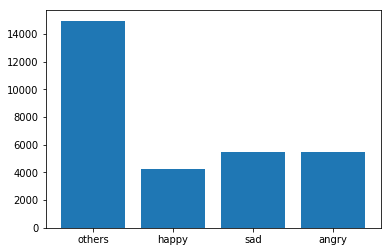

In [13]:
plt.bar(categories,category_counts,tick_label=tokens,align='center')

In [14]:
category_counts

array([14948,  4243,  5463,  5506])

In [15]:
y=np.array(y)
idx_others=np.where(y==0)[0]

In [16]:
idx = np.r_[np.where(y==1)[0],np.where(y==2)[0],np.where(y==3)[0]]

In [17]:
idx.shape

(15212,)

In [44]:
deepmoji_train = deepmoji_train_all[idx]
emoji_train = emoji_train_all[idx]
y_train = y[idx]

In [45]:
test_y_all = np.array(test_y_all)
idx_test = np.r_[np.where(test_y_all==1)[0],np.where(test_y_all==2)[0],np.where(test_y_all==3)[0]]
idx_test.shape

(832,)

In [46]:
test_y_all = np.array(test_y_all)
test_y = test_y_all[idx_test]
deepmoji_test = deepmoji_test_all[idx_test]
emoji_test = emoji_test_all[idx_test]

In [28]:
categories_t, category_counts_t = np.unique(test_y,return_counts=True)

<BarContainer object of 3 artists>

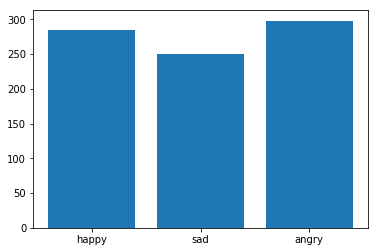

In [29]:
plt.bar(categories_t,category_counts_t,tick_label=tokens[1:],align='center')

In [30]:
category_counts_t

array([284, 250, 298])

In [31]:
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn.linear_model import LogisticRegression

In [1]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def print_metrics(mc_prediction, test_y = test_y):
    print(metrics.classification_report(test_y, mc_prediction, target_names=tokens[1:]))
    print("Accuracy:", metrics.accuracy_score(test_y, mc_prediction))
    print("Precision:", metrics.precision_score(test_y, mc_prediction, average='micro'))
    print("Recall:", metrics.recall_score(test_y, mc_prediction, average='micro'))
    print("F1 macro score: ", metrics.f1_score(test_y, mc_prediction, average='macro'))
    print("F1 score: ", metrics.f1_score(test_y, mc_prediction, average='micro'))
    #print("Confusion Matrix: \n", metrics.confusion_matrix(mc_Y_test, mc_prediction))
    plot_confusion_matrix(metrics.confusion_matrix(test_y, mc_prediction), tokens[1:])

NameError: name 'plt' is not defined

### Logistic Regression

In [33]:
LR = Pipeline([('scaler', MinMaxScaler()), ('clf', LogisticRegression(random_state=0))])
#LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

             precision    recall  f1-score   support

      happy       0.91      0.87      0.89       284
        sad       0.88      0.85      0.86       250
      angry       0.88      0.93      0.90       298

avg / total       0.89      0.89      0.89       832

Accuracy: 0.8882211538461539
Precision: 0.8884265081972346
Recall: 0.8860417808866622
F1 score:  0.886749578222941
Confusion matrix, without normalization
[[248  18  18]
 [ 16 213  21]
 [  8  12 278]]


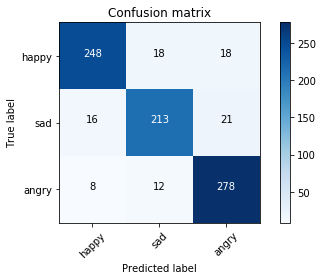

In [34]:
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

      happy       0.91      0.89      0.90       284
        sad       0.89      0.84      0.87       250
      angry       0.88      0.94      0.91       298

avg / total       0.89      0.89      0.89       832

Accuracy: 0.8942307692307693
Precision: 0.8950331406662059
Recall: 0.8912660301855878
F1 score:  0.8924417596752109
Confusion matrix, without normalization
[[253  14  17]
 [ 18 210  22]
 [  6  11 281]]


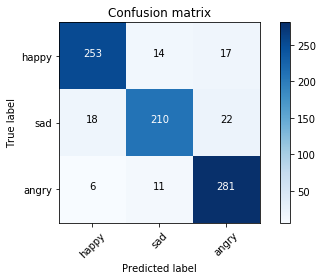

In [35]:
LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

      happy       0.85      0.86      0.86       284
        sad       0.83      0.77      0.80       250
      angry       0.84      0.88      0.86       298

avg / total       0.84      0.84      0.84       832

Accuracy: 0.8401442307692307
Precision: 0.8392602672839974
Recall: 0.8366235624035038
F1 score:  0.8374185897923648
Confusion matrix, without normalization
[[245  18  21]
 [ 30 192  28]
 [ 14  22 262]]


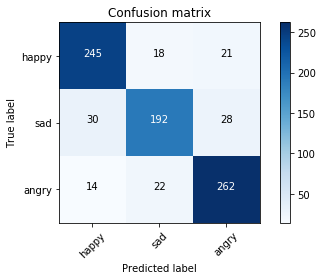

In [47]:
LR = LogisticRegression(random_state=0).fit(emoji_train, y_train) 
print_metrics(LR.predict(emoji_test))

### Naive Bayes

             precision    recall  f1-score   support

      happy       0.82      0.86      0.84       284
        sad       0.82      0.76      0.79       250
      angry       0.86      0.87      0.87       298

avg / total       0.83      0.83      0.83       832

Accuracy: 0.8341346153846154
Precision: 0.8331638288447962
Recall: 0.8305460503513249
F1 score:  0.8312457331325257
Confusion matrix, without normalization
[[244  21  19]
 [ 37 190  23]
 [ 18  20 260]]


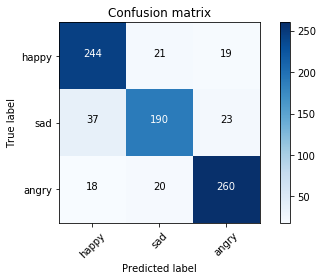

In [36]:
mc_nb = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
mc_nb.fit(deepmoji_train, y_train)
print_metrics(mc_nb.predict(deepmoji_test))

             precision    recall  f1-score   support

      happy       0.81      0.73      0.77       284
        sad       0.80      0.74      0.77       250
      angry       0.74      0.86      0.80       298

avg / total       0.78      0.78      0.78       832

Accuracy: 0.7800480769230769
Precision: 0.785091522157996
Recall: 0.7769368245265779
F1 score:  0.77839122766659
Confusion matrix, without normalization
[[208  23  53]
 [ 30 184  36]
 [ 18  23 257]]


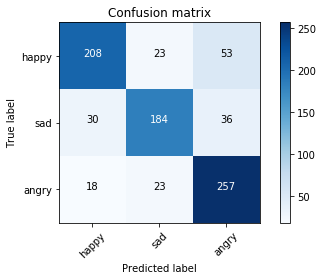

In [48]:
mc_nb = Pipeline([('clf', MultinomialNB())])
mc_nb.fit(emoji_train, y_train)
print_metrics(mc_nb.predict(emoji_test))

### SVM - One vs One

             precision    recall  f1-score   support

      happy       0.88      0.89      0.89       284
        sad       0.82      0.79      0.80       250
      angry       0.85      0.88      0.86       298

avg / total       0.85      0.85      0.85       832

Accuracy: 0.8533653846153846
Precision: 0.8515263628928312
Recall: 0.8503876232788228
F1 score:  0.8508156338568841
Confusion matrix, without normalization
[[252  18  14]
 [ 22 197  31]
 [ 11  26 261]]


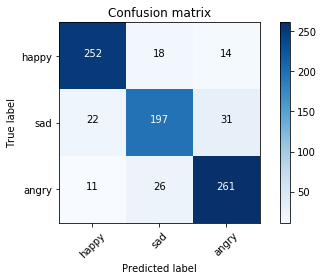

In [49]:
mc_svm_ovo = svm.SVC(decision_function_shape='ovo', kernel='linear', C=100)

mc_svm_ovo.fit(emoji_train, y_train)
print_metrics(mc_svm_ovo.predict(emoji_test))

### SVM One vs Rest

             precision    recall  f1-score   support

      happy       0.88      0.89      0.89       284
        sad       0.82      0.79      0.80       250
      angry       0.85      0.88      0.86       298

avg / total       0.85      0.85      0.85       832

Accuracy: 0.8533653846153846
Precision: 0.8515263628928312
Recall: 0.8503876232788228
F1 score:  0.8508156338568841
Confusion matrix, without normalization
[[252  18  14]
 [ 22 197  31]
 [ 11  26 261]]


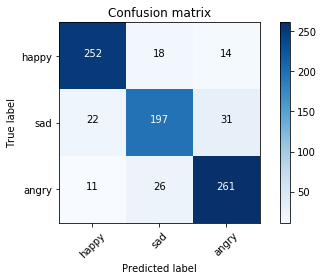

In [50]:
mc_svm_ovr = svm.SVC(decision_function_shape='ovr', kernel='linear', C=100)
mc_svm_ovr.fit(emoji_train, y_train)
print_metrics(mc_svm_ovr.predict(emoji_test))